In this notebook, we show the dynamical relaxation time and plot out a few contours.

# Init

In [2]:
from __future__ import division

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys,os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [5]:
from matplotlib import rcParams, rc

In [6]:
import spc
import model
import chi2
import margin

import numpy as np
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from scipy.integrate import quad
import h5py
import glob
import re

import scan
import pickle
import glob
from multiprocessing import Pool
from contextlib import closing

from matplotlib import cm
from tqdm import tqdm

In [9]:
plt.rcParams.update({'font.size': 12})

In [10]:
path = '../data/SPARC.txt'
data = spc.readSPARC(path)

path = '../data/SPARC_Lelli2016c.txt'
spc.readSPARC_ext(data, path)

In [11]:
data2 = {}
for gal in data:
    data2[gal.name] = gal

# Functions

In [ ]:
# def model.tau(f, m, v=57., rho=0.003):
#     """ relaxation time computation [Gyr]
#     :param f: fraction
#     :param m: scalar mass [eV]
#     :param v: dispersion [km/s]
#     :param rho: DM density [Msun/pc**3]    
    
#     """
#     return 0.6 * 1./f**2 * (m/(1.e-22))**3 * (v/100)**6 * (rho/0.1)**(-2)

# model.tau(0.2, 1e-22, 100, 0.1) 

In [11]:
# def reconstruct_density(gal, flg_give_R=False):
#     """ reconstruct the local density based on the rotaion curve
    
#     """
#     V = gal.Vobs
#     r = gal.R
#     M_unit = 232501.397985234 # Msun computed with km/s, kpc
#     M = V**2 * r * M_unit
#     r_mid = (r[1:] + r[:-1]) /2.
#     dr = r[1:] - r[:-1]
#     rho = (M[1:] - M[:-1]) / 4./np.pi/r_mid**2 / dr /1e9 #[Msun/pc**3]
#     if flg_give_R:
#         return (r_mid, rho)
#     else:
#         return rho

# Check the data

In [13]:
#gal = data2['UGC01281']
gal = data2['UGC04325']
print(gal.Vobs[-1])
model.reconstruct_density(gal)

91.5


array([0.12978481, 0.07105807, 0.03229302, 0.01710595, 0.01223297,
       0.00880299, 0.00460103])

<IPython.core.display.Javascript object>


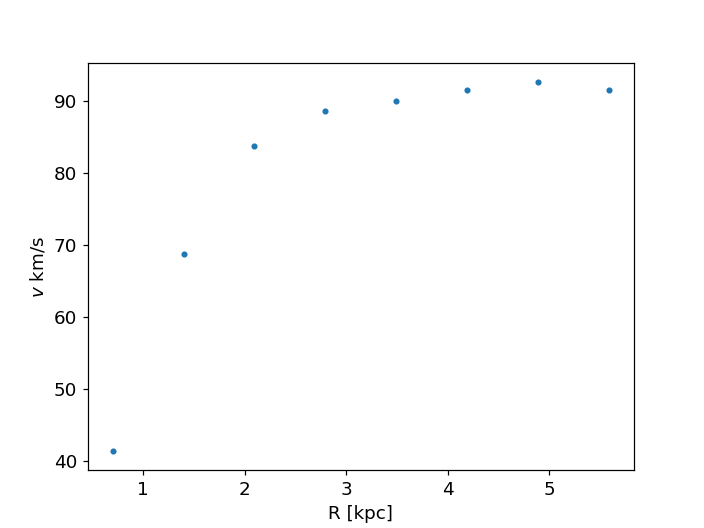

Text(0,0.5,'$v$ km/s')

In [14]:
plt.subplots()
plt.plot(gal.R, gal.Vobs, '.')
plt.xlabel('R [kpc]')
plt.ylabel(r'$v$ km/s')

<IPython.core.display.Javascript object>


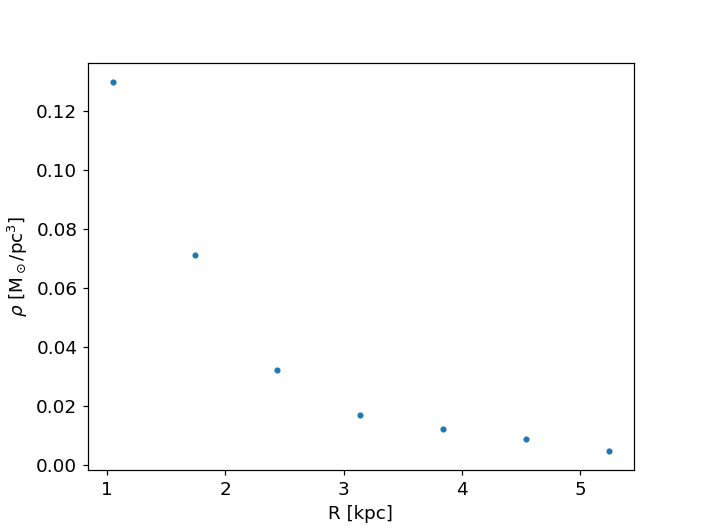

Text(0,0.5,'$\\rho$ [M$_\\odot$/pc$^3$]')

In [15]:
r_arr, rho_arr = model.reconstruct_density(gal, flg_give_R=True)
plt.subplots()
plt.plot(r_arr, rho_arr, '.')
plt.xlabel('R [kpc]')
plt.ylabel(r'$\rho$ [M$_\odot$/pc$^3$]')

<IPython.core.display.Javascript object>


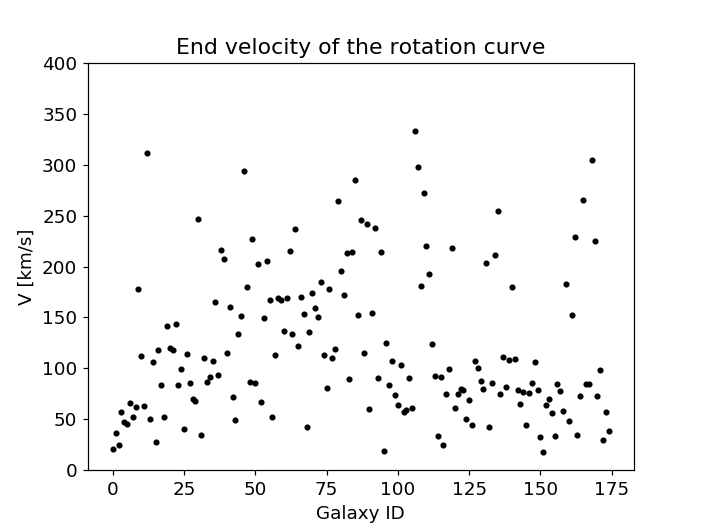

Text(0.5,1,'End velocity of the rotation curve')

In [16]:
vf_arr = []
rhof_arr = []

for gal in data:
    rho_f = model.reconstruct_density(gal)[-1]
    v_f = gal.Vobs[-1]
    vf_arr.append(v_f)
    rhof_arr.append(rho_f)    
    
plt.subplots()
plt.plot(vf_arr, 'k.')
plt.ylim(0, 400)
plt.xlabel('Galaxy ID')
plt.ylabel('V [km/s]')
plt.title('End velocity of the rotation curve')

<IPython.core.display.Javascript object>


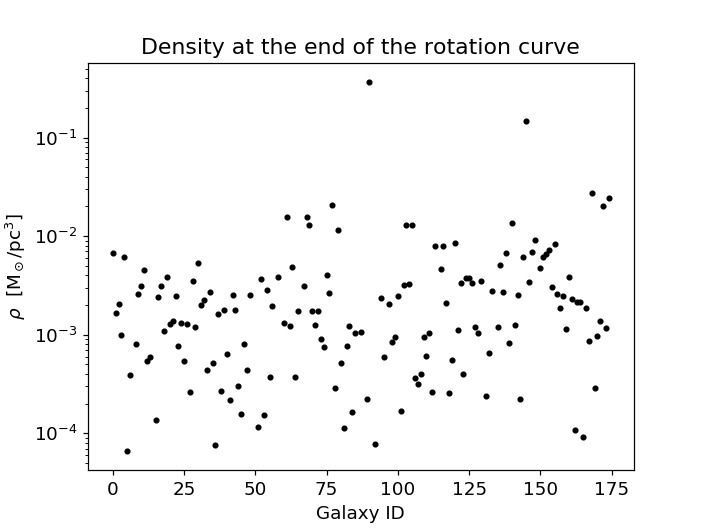

Text(0.5,1,'Density at the end of the rotation curve')

In [17]:
plt.subplots()
plt.plot(rhof_arr, 'k.')
plt.yscale('log')
plt.xlabel('Galaxy ID')
plt.ylabel(r'$\rho$  [M$_\odot$/pc$^3$]')
plt.title('Density at the end of the rotation curve')

<IPython.core.display.Javascript object>


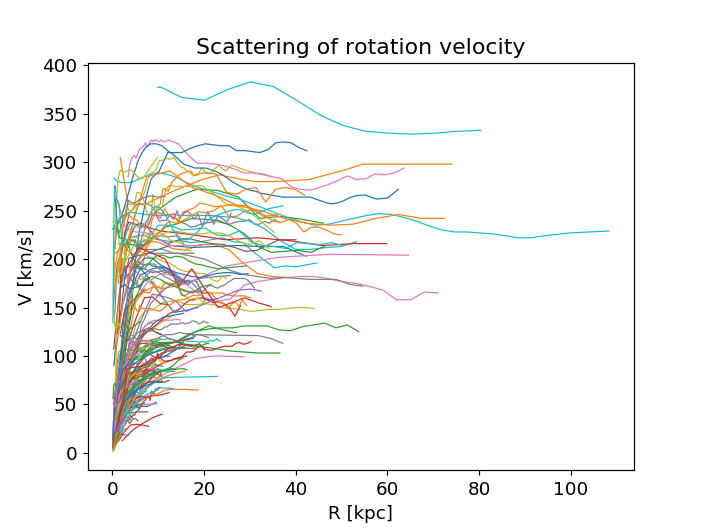

In [18]:
plt.subplots()
plt.title("Scattering of rotation velocity")
plt.xlabel('R [kpc]')
plt.ylabel('V [km/s]')

for name, gal in data2.items():
    plt.plot(gal.R, gal.Vobs, lw='0.8')

# Relaxatin time at last data point

In [19]:
f1 = 0.85
f2 = 0.15
m1_arr = np.logspace(-25, -19, 100)
m2_arr = np.logspace(-25, -19, 100)

m1_mesh, m2_mesh = np.meshgrid(m1_arr, m2_arr, indexing='ij')
m1_flat, m2_flat = m1_mesh.reshape(-1), m2_mesh.reshape(-1)

In [20]:
tau1_flat = []
tau1_self_flat = []

for i in range(len(m1_flat)):
    m1 = m1_flat[i]
    m2 = m2_flat[i]
    tau1 = 1./(1./model.tau(f1, m1) + 1./model.tau(f2, m2))
    tau1_self = model.tau(f1, m1) 
    
    tau1_flat.append(tau1)
    tau1_self_flat.append(tau1_self)
    
tau1_flat = np.asarray(tau1_flat)
tau1_self_flat = np.asarray(tau1_self_flat)

tau1_mesh = tau1_flat.reshape(m1_mesh.shape)
tau1_self_mesh = tau1_self_flat.reshape(m1_mesh.shape)

<IPython.core.display.Javascript object>


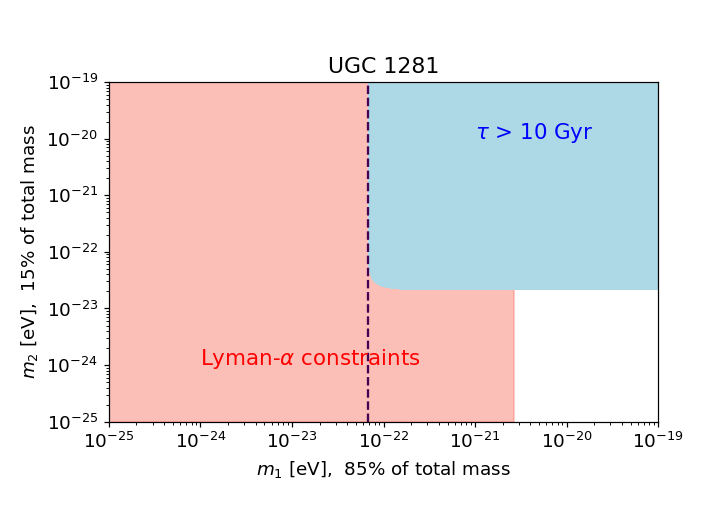

In [21]:
_, ax = plt.subplots()
plt.contourf(m1_mesh, m2_mesh, tau1_mesh, levels=[10, np.inf], colors='lightblue')
plt.contour(m1_mesh, m2_mesh, tau1_self_mesh, levels=[10], linestyles={'dashed'})
plt.fill_betweenx(np.logspace(-25, -19), 1e-25, 2.66e-21, color='salmon', alpha=0.5, zorder=0)

#label
plt.text(1e-24, 1e-24, r"Lyman-$\alpha$ constraints", color='red', fontsize=14)
plt.text(1e-21, 1e-20, r"$\tau$ > 10 Gyr", color='blue', fontsize=14)


plt.xscale('log')
plt.yscale('log')
plt.xlabel('$m_1$ [eV],  85% of total mass')
plt.ylabel('$m_2$ [eV],  15% of total mass')
plt.xlim(1e-25, 1e-19)
plt.ylim(1e-25, 1e-19)
plt.title(r"UGC 1281")
ax.set_aspect(aspect=0.618)
plt.tight_layout()
#plt.savefig('./sol_relaxation_contour.pdf')

In [37]:
# check relaxation time at the last data point

In [22]:
#f1 = 0.85
f1 = 1.
m1_target_arr = []
vf_arr = []
rhof_arr = []
m1_arr = np.logspace(-25, -19, 100)

for gal in data:
    rho_f = model.reconstruct_density(gal)[-1] # last data point is selected
    v_f = gal.Vobs[-1] # last data point
    vf_arr.append(v_f)
    rhof_arr.append(rho_f)
    tau1_self_arr = []    
    
    for m1 in m1_arr:
        tau1_self = model.tau(f1, m1, v=v_f, rho=rho_f) 
        tau1_self_arr.append(tau1_self)
    tau1_self_arr = np.asarray(tau1_self_arr)
    m1_target = np.exp(np.interp(np.log(10), np.log(tau1_self_arr), np.log(m1_arr)))
    m1_target_arr.append(m1_target)

<IPython.core.display.Javascript object>


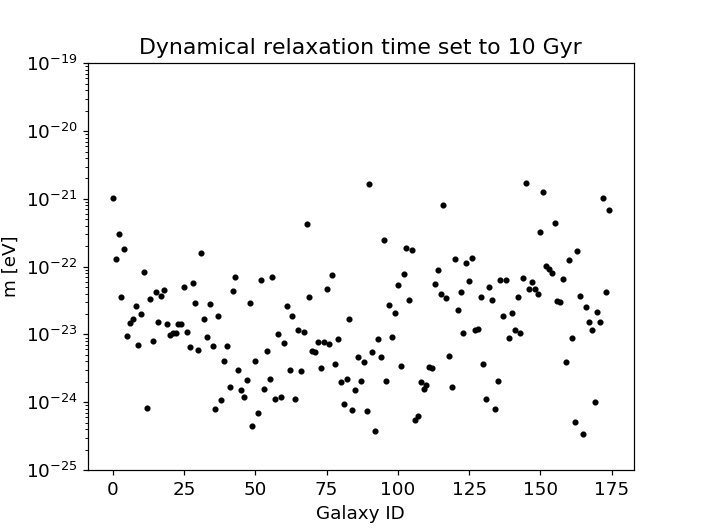

Text(0.5,1,'Dynamical relaxation time set to 10 Gyr')

In [23]:
plt.subplots()
plt.plot(m1_target_arr, 'k.')
plt.yscale('log')
plt.ylim(1e-25, 1e-19)
plt.xlabel('Galaxy ID')
plt.ylabel('m [eV]')
plt.title('Dynamical relaxation time set to 10 Gyr')

<IPython.core.display.Javascript object>


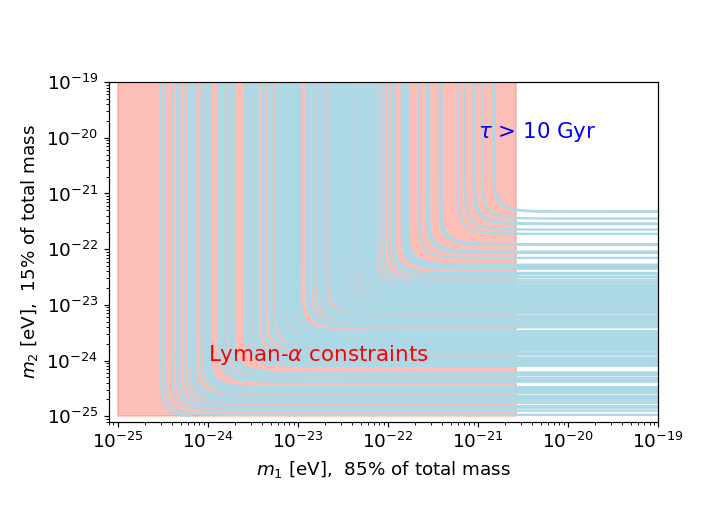

In [24]:
_, ax = plt.subplots()
plt.fill_betweenx(np.logspace(-25, -19), 1e-25, 2.66e-21, color='salmon', alpha=0.5, zorder=0)

f1 = 0.85
f2 = 0.15
m1_arr = np.logspace(-25, -19, 50)
m2_arr = np.logspace(-25, -19, 50)

m1_mesh, m2_mesh = np.meshgrid(m1_arr, m2_arr, indexing='ij')
m1_flat, m2_flat = m1_mesh.reshape(-1), m2_mesh.reshape(-1)

for gal in data:
    rho_f = model.reconstruct_density(gal)[-1]
    v_f = gal.Vobs[-1]
    tau1_flat = []
    tau1_self_flat = []

    for i in range(len(m1_flat)):
        m1 = m1_flat[i]
        m2 = m2_flat[i]
        tau1 = 1./(1./model.tau(f1, m1, v=v_f, rho=rho_f) + 1./model.tau(f2, m2, v=v_f, rho=rho_f))
        tau1_self = model.tau(f1, m1, v=v_f, rho=rho_f) 

        tau1_flat.append(tau1)
        tau1_self_flat.append(tau1_self)

    tau1_flat = np.asarray(tau1_flat)
    tau1_self_flat = np.asarray(tau1_self_flat)

    tau1_mesh = tau1_flat.reshape(m1_mesh.shape)
    tau1_self_mesh = tau1_self_flat.reshape(m1_mesh.shape)    
    
    plt.contour(m1_mesh, m2_mesh, tau1_mesh, levels=[10], colors='lightblue')

#label
plt.text(1e-24, 1e-24, r"Lyman-$\alpha$ constraints", color='red', fontsize=14)
plt.text(1e-21, 1e-20, r"$\tau$ > 10 Gyr", color='blue', fontsize=14)


plt.xscale('log')
plt.yscale('log')
plt.xlabel('$m_1$ [eV],  85% of total mass')
plt.ylabel('$m_2$ [eV],  15% of total mass')
plt.xlim(8e-26, 1e-19)
plt.ylim(8e-26, 1e-19)
ax.set_aspect(aspect=0.618)
plt.tight_layout()
#plt.savefig('./sol_relaxation_contour.pdf')

# Check relaxation time at the radius predicted by the SH relation 

In [99]:
# # compute the raius predicted by the SH relation 
# def rc_SH(m, gal):
#     """ the radius predicted by the SH relation [kpc]
#     """
#     Msol = model.M_SH(m, gal) # the soliton mass predicted by SH relation
#     rc = 2.29e-3 * (Msol/1e11)**(-1) * (m/1e-22)**(-2)
#     return rc

# def model.relaxation_at_rc(m, gal, f, verbose=0, multiplier=1.):
#     """ relaxation time at rc*multiplier, where rc is predicted by the SH relation [Gyr]
#     """
#     rc_eff = rc_SH(m, gal)*multiplier # this is rc*multiplier
#     if verbose > 1:
#         print('rc_SH=%s' %rc_eff)    

#     r_arr, rho_arr = reconstruct_density(gal, flg_give_R=True)
#     rho_at_rc = np.interp(rc_eff, r_arr, rho_arr)
#     if verbose > 1:
#         print('rho_at_rc=%s' %rho_at_rc)
    
#     v_at_rc = np.interp(rc_eff, gal.R, gal.Vobs)
#     v_inside_rc_arr = gal.Vobs[gal.R < rc_eff]
#     # make sure to use the max of v inside rc, to be conservative
#     if len(np.array(v_inside_rc_arr)) > 0:
#         v_disp = max(v_at_rc, max(v_inside_rc_arr))
#     else:
#         v_disp = v_at_rc
#     if verbose > 1:
#         print('v_at_rc=%s' %v_at_rc)
    
#     #relax_time = 0.6 * 1/f**2 * (m/1e-22)**3 * (v_at_rc/100)**6 * (rho_at_rc/0.1)**(-2)
#     relax_time = 0.6 * 1/f**2 * (m/1e-22)**3 * (v_disp/100)**6 * (rho_at_rc/0.1)**(-2)
    
#     return relax_time

In [225]:
# gal = data2['UGC01281']
# m = 1e-21
# print('relaxation = %s' %(model.relaxation_at_rc(m, gal, 0.8, verbose=2)))

<IPython.core.display.Javascript object>


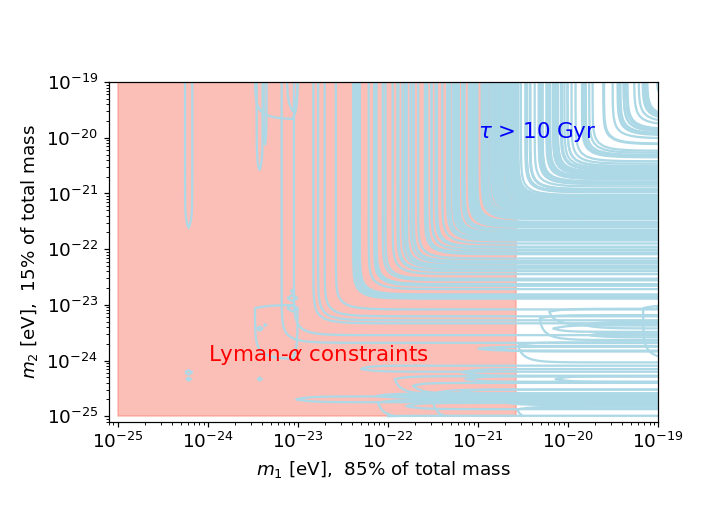

  0%|          | 0/175 [00:00<?, ?it/s]/a/home/cc/students/physics/chensun/app/anaconda2/lib/python2.7/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
100%|██████████| 175/175 [03:16<00:00,  1.12s/it]


In [25]:
_, ax = plt.subplots()
plt.fill_betweenx(np.logspace(-25, -19), 1e-25, 2.66e-21, color='salmon', alpha=0.5, zorder=0)

f1 = 0.85
f2 = 0.15
m1_arr = np.logspace(-25, -19, 100)
m2_arr = np.logspace(-25, -19, 100)

m1_mesh, m2_mesh = np.meshgrid(m1_arr, m2_arr, indexing='ij')
m1_flat, m2_flat = m1_mesh.reshape(-1), m2_mesh.reshape(-1)

for gal in tqdm(data):
    rho_f = model.reconstruct_density(gal)[-1]
    # v_f = gal.Vobs[-1]
    tau1_flat = []
    tau1_self_flat = []

    for i in range(len(m1_flat)):
        m1 = m1_flat[i]
        m2 = m2_flat[i]
        tau1 = 1./(1./model.relaxation_at_rc(m1, gal, f1) + 1./model.relaxation_at_rc(m2, gal, f2))
        tau1_self = model.relaxation_at_rc(m1, gal, f1) 

        tau1_flat.append(tau1)
        tau1_self_flat.append(tau1_self)

    tau1_flat = np.asarray(tau1_flat)
    tau1_self_flat = np.asarray(tau1_self_flat)

    tau1_mesh = tau1_flat.reshape(m1_mesh.shape)
    tau1_self_mesh = tau1_self_flat.reshape(m1_mesh.shape)    
    
    plt.contour(m1_mesh, m2_mesh, tau1_mesh, levels=[10], colors='lightblue')


#label
plt.text(1e-24, 1e-24, r"Lyman-$\alpha$ constraints", color='red', fontsize=14)
plt.text(1e-21, 1e-20, r"$\tau$ > 10 Gyr", color='blue', fontsize=14)


plt.xscale('log')
plt.yscale('log')
plt.xlabel('$m_1$ [eV],  85% of total mass')
plt.ylabel('$m_2$ [eV],  15% of total mass')
plt.xlim(8e-26, 1e-19)
plt.ylim(8e-26, 1e-19)
ax.set_aspect(aspect=0.618)
plt.tight_layout()


In [63]:
#gal = data2['NGC0100']
gal = data2['UGC04325']
#gal = data2['UGC01281']
#gal = data2['NGC3769']
#gal = data2['NGC3877']
#gal = data2['NGC6503']
f1 = 0.85
f2 = 0.15
m1_arr = np.logspace(-25.2, -18.8, 100)
m2_arr = np.logspace(-25.2, -18.8, 100)

m1_mesh, m2_mesh = np.meshgrid(m1_arr, m2_arr, indexing='ij')
m1_flat, m2_flat = m1_mesh.reshape(-1), m2_mesh.reshape(-1)

In [64]:
tau1_flat = []
tau1_self_flat = []
tau1_self_flat2 = []
r_over_rc = 2.
#r_over_rc2 = 10.655
r_over_rc2 = 5.

for i in range(len(m1_flat)):
    m1 = m1_flat[i]
    m2 = m2_flat[i]
    tau1 = 1./(1./model.relaxation_at_rc(m1, gal, f1, multiplier=r_over_rc) + 1./model.relaxation_at_rc(m2, gal, f2, multiplier=r_over_rc))
    tau1_flat.append(tau1)
    
    tau1_self = model.relaxation_at_rc(m1, gal, 1, multiplier=r_over_rc) 
    tau1_self_flat.append(tau1_self)

    tau1_self = model.relaxation_at_rc(m1, gal, 1, multiplier=r_over_rc2) 
    tau1_self_flat2.append(tau1_self)
    
tau1_flat = np.asarray(tau1_flat)
tau1_self_flat = np.asarray(tau1_self_flat)
tau1_self_flat2 = np.asarray(tau1_self_flat2)

tau1_mesh = tau1_flat.reshape(m1_mesh.shape)
tau1_self_mesh = tau1_self_flat.reshape(m1_mesh.shape)
tau1_self_mesh2 = tau1_self_flat2.reshape(m1_mesh.shape)

<IPython.core.display.Javascript object>


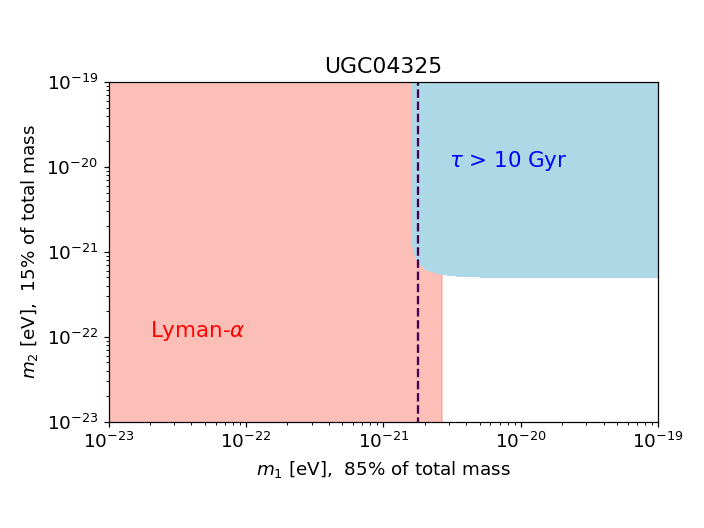

In [65]:
_, ax = plt.subplots()
plt.contourf(m1_mesh, m2_mesh, tau1_mesh, levels=[10, np.inf], colors='lightblue')
plt.contour(m1_mesh, m2_mesh, tau1_self_mesh, levels=[10], linestyles={'dashed'})
#plt.contour(m1_mesh, m2_mesh, tau1_self_mesh2, levels=[10], linestyles={'dashed'})
#plt.contourf(m1_mesh, m2_mesh, tau1_self_mesh2, levels=[10,np.inf], colors='green')
plt.fill_betweenx(np.logspace(-25, -19), 1e-25, 2.66e-21, color='salmon', alpha=0.5, zorder=0)

#label
plt.text(2e-23, 1e-22, r"Lyman-$\alpha$", color='red', fontsize=14)
plt.text(3e-21, 1e-20, r"$\tau$ > 10 Gyr", color='blue', fontsize=14)


plt.xscale('log')
plt.yscale('log')
plt.xlabel('$m_1$ [eV],  85% of total mass')
plt.ylabel('$m_2$ [eV],  15% of total mass')
plt.xlim(1e-23, 1e-19)
plt.ylim(1e-23, 1e-19)
ax.set_aspect(aspect=0.618)
plt.title('%s' %gal.name)
plt.tight_layout()
#plt.savefig('./plots/relaxation_time_%s.pdf' %gal.name)

In [29]:
gal = data2['UGC04325']
m = 1e-22
print('relaxation = %s' %(model.relaxation_at_rc(m, gal, 0.85, verbose=2)))

rc_SH=0.18227337611354555
rho_at_rc=0.12978481012244342
v_at_rc=41.3
relaxation = 0.0024466169307464083


<IPython.core.display.Javascript object>


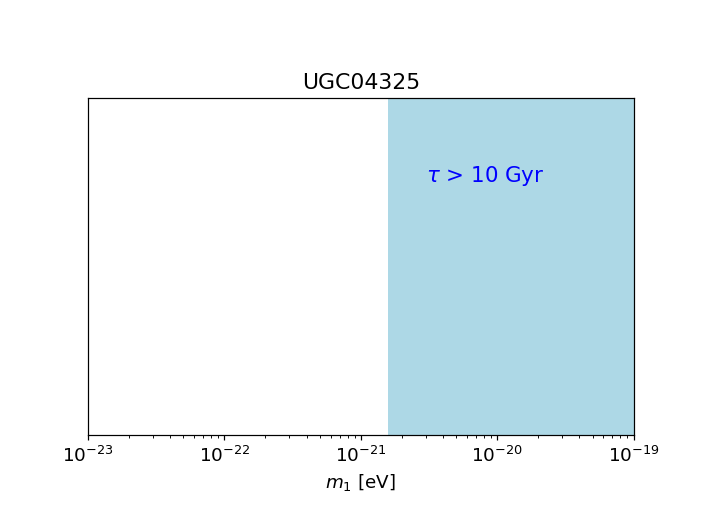

<IPython.core.display.Javascript object>


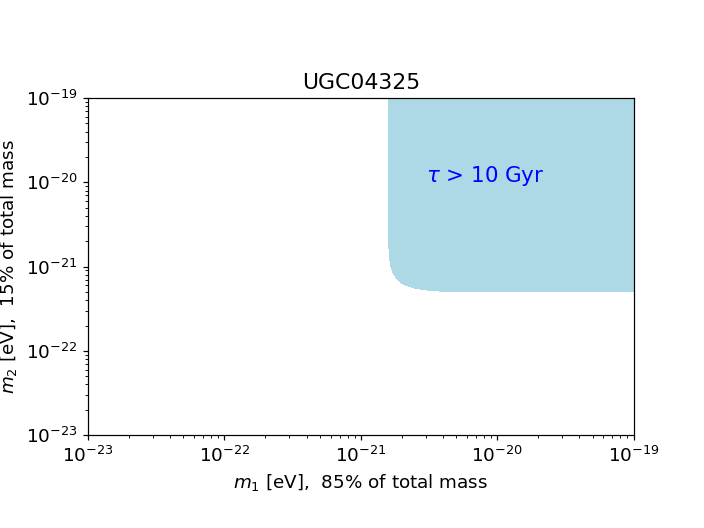

In [30]:
#gal = data2['NGC0100']
gal = data2['UGC04325']
#gal = data2['UGC01281']
#gal = data2['NGC3769']
#gal = data2['NGC3877']
#gal = data2['NGC6503']
f1 = 0.85
f2 = 0.15
m1_arr = np.logspace(-25.2, -18.8, 100)
m2_arr = np.logspace(-25.2, -18.8, 100)

m1_mesh, m2_mesh = np.meshgrid(m1_arr, m2_arr, indexing='ij')
m1_flat, m2_flat = m1_mesh.reshape(-1), m2_mesh.reshape(-1)

tau1_flat = []
tau1_self_flat = []
tau1_self_flat2 = []
r_over_rc = 2.
#r_over_rc2 = 10.655
r_over_rc2 = 5.

for i in range(len(m1_flat)):
    m1 = m1_flat[i]
    m2 = m2_flat[i]
    tau1 = 1./(1./model.relaxation_at_rc(m1, gal, f1, multiplier=r_over_rc) + 1./model.relaxation_at_rc(m2, gal, f2, multiplier=r_over_rc))
    tau1_flat.append(tau1)
    
    tau1_self = model.relaxation_at_rc(m1, gal, f1, multiplier=r_over_rc) 
    tau1_self_flat.append(tau1_self)

    tau1_self = model.relaxation_at_rc(m1, gal, f1, multiplier=r_over_rc2) 
    tau1_self_flat2.append(tau1_self)
    
tau1_flat = np.asarray(tau1_flat)
tau1_self_flat = np.asarray(tau1_self_flat)
tau1_self_flat2 = np.asarray(tau1_self_flat2)

tau1_mesh = tau1_flat.reshape(m1_mesh.shape)
tau1_self_mesh = tau1_self_flat.reshape(m1_mesh.shape)
tau1_self_mesh2 = tau1_self_flat2.reshape(m1_mesh.shape)

_, ax = plt.subplots()
plt.contourf(m1_mesh, m2_mesh, tau1_self_mesh, levels=[10, np.inf], colors='lightblue')

#label
#plt.text(2e-23, 1e-22, r"Lyman-$\alpha$", color='red', fontsize=14)
plt.text(3e-21, 1e-20, r"$\tau$ > 10 Gyr", color='blue', fontsize=14)


plt.xscale('log')
plt.yscale('log')
plt.xlabel('$m_1$ [eV]')
#plt.ylabel('$m_2$ [eV],  15% of total mass')
plt.ylabel(r'$\;$')
plt.xlim(1e-23, 1e-19)
plt.ylim(1e-23, 1e-19)

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

ax.set_aspect(aspect=0.618)
plt.title('%s' %gal.name)
#plt.tight_layout()
plt.savefig('./plots/relaxation_time_one_species_%s.pdf' %gal.name)







_, ax = plt.subplots()
plt.contourf(m1_mesh, m2_mesh, tau1_mesh, levels=[10, np.inf], colors='lightblue')

#label
#plt.text(2e-23, 1e-22, r"Lyman-$\alpha$", color='red', fontsize=14)
plt.text(3e-21, 1e-20, r"$\tau$ > 10 Gyr", color='blue', fontsize=14)


plt.xscale('log')
plt.yscale('log')
plt.xlabel('$m_1$ [eV],  85% of total mass')
plt.ylabel('$m_2$ [eV],  15% of total mass')
plt.xlim(1e-23, 1e-19)
plt.ylim(1e-23, 1e-19)
ax.set_aspect(aspect=0.618)
plt.title('%s' %gal.name)
#plt.tight_layout()
plt.savefig('./plots/relaxation_time_two_species_%s.pdf' %gal.name)



In [ ]:
# change the fraction

<IPython.core.display.Javascript object>


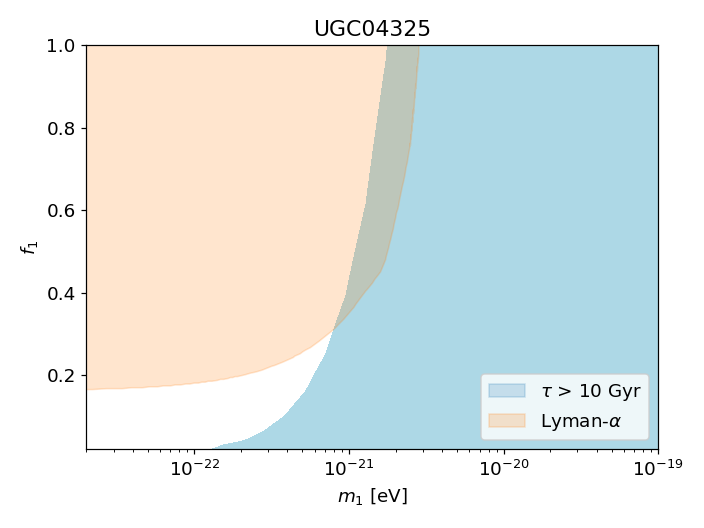

In [73]:
#gal = data2['NGC0100']
gal = data2['UGC04325']
#gal = data2['UGC01281']
#gal = data2['NGC3769']
#gal = data2['NGC3877']
#gal = data2['NGC6503']

m2 = 1.e-23 # [eV]
#f2 = 0.15
m1_arr = np.logspace(-25.2, -18.8, 50)
f1_arr = np.linspace(0., 1., 50)

m1_mesh, f1_mesh = np.meshgrid(m1_arr, f1_arr, indexing='ij')
m1_flat, f1_flat = m1_mesh.reshape(-1), f1_mesh.reshape(-1)

tau1_flat = []
tau1_self_flat = []
r_over_rc = 2.

for i in range(len(m1_flat)):
    m1 = m1_flat[i]
    f1 = f1_flat[i]
    f2 = 1.-f1
    tau1 = 1./(1./model.relaxation_at_rc(m1, gal, f1, multiplier=r_over_rc) 
               + 1./model.relaxation_at_rc(m2, gal, f2, multiplier=r_over_rc))
    tau1_flat.append(tau1)
    
    tau1_self = model.relaxation_at_rc(m1, gal, f1, multiplier=r_over_rc) 
    tau1_self_flat.append(tau1_self)

    
tau1_flat = np.asarray(tau1_flat)
tau1_self_flat = np.asarray(tau1_self_flat)

tau1_mesh = tau1_flat.reshape(m1_mesh.shape)
tau1_self_mesh = tau1_self_flat.reshape(m1_mesh.shape)



_, ax = plt.subplots()
#plt.contourf(m1_mesh, f1_mesh, tau1_mesh, levels=[10, np.inf], colors='lightblue')
plt.contourf(m1_mesh, f1_mesh, tau1_self_mesh, levels=[10, np.inf], colors='lightblue')
plt.fill_between([1,2], 101, 100, color='C0', label=r"$\tau$ > 10 Gyr", alpha=0.2)


#label
#plt.text(2e-23, 1e-22, r"Lyman-$\alpha$", color='red', fontsize=14)
#plt.text(3e-21, 0.5, r"$\tau$ > 10 Gyr", color='blue', fontsize=14)


plt.xscale('log')
#plt.yscale('log')
plt.xlabel('$m_1$ [eV]')
#plt.ylabel('$m_2$ [eV],  15% of total mass')
plt.ylabel(r'$f_1$')
plt.xlim(2e-23, 1e-19)
plt.ylim(0.02, 1.)


# overlay with Kobayashi
path = '../data/Kobayashi2017.csv'
data_lym_arr = np.loadtxt(path, delimiter=',')
x = data_lym_arr[:,0]
y = data_lym_arr[:,1]
x = np.insert(x, 0, 1e-25)
y = np.insert(y, 0, y[0])
plt.fill_between(x, y, 100, color='C1', label=r'Lyman-$\alpha$', alpha=0.2)
plt.legend(loc=4)
plt.tight_layout()



ax.set_aspect(aspect=0.618)
plt.title('%s' %gal.name)
plt.tight_layout()
plt.savefig('./plots/relaxation_time_f1_m1_%s.pdf' %gal.name)

<IPython.core.display.Javascript object>


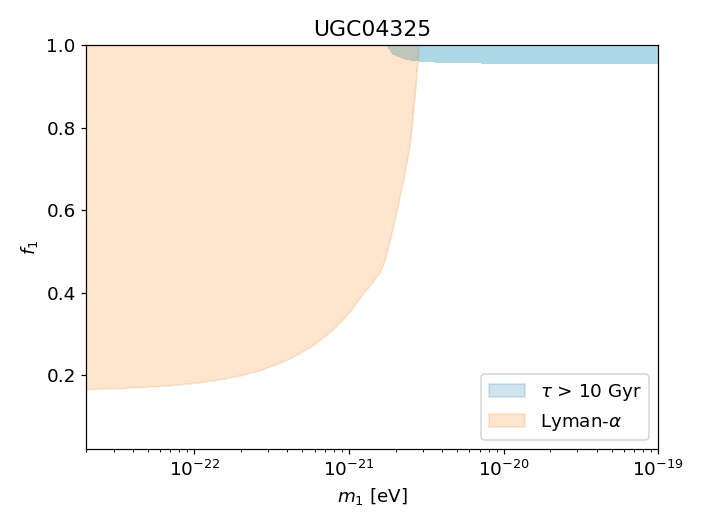

In [74]:
_, ax = plt.subplots()
plt.contourf(m1_mesh, f1_mesh, tau1_mesh, levels=[10, np.inf], colors='lightblue')
plt.fill_between([1,2], 101, 100, color='C0', label=r"$\tau$ > 10 Gyr", alpha=0.2)

#label
#plt.text(2e-23, 1e-22, r"Lyman-$\alpha$", color='red', fontsize=14)
#plt.text(3e-21, 0.5, r"$\tau$ > 10 Gyr", color='blue', fontsize=14)


plt.xscale('log')
#plt.yscale('log')
plt.xlabel('$m_1$ [eV]')
plt.ylabel('$f_1$')
plt.xlim(2e-23, 1e-19)
plt.ylim(0.02, 1.)


plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=True) # labels along the bottom edge are off



# overlay with Kobayashi
path = '../data/Kobayashi2017.csv'
data_lym_arr = np.loadtxt(path, delimiter=',')
x = data_lym_arr[:,0]
y = data_lym_arr[:,1]
x = np.insert(x, 0, 1e-25)
y = np.insert(y, 0, y[0])
plt.fill_between(x, y, 100, color='C1', label=r'Lyman-$\alpha$', alpha=0.2)
plt.legend(loc=4)
plt.tight_layout()

# TODO: add lyman alpha constraints for the second species 



ax.set_aspect(aspect=0.618)
plt.title('%s' %gal.name)
plt.tight_layout()
plt.savefig('./plots/relaxation_time_f1_m1_two_species_%s.pdf' %gal.name)

In [62]:
model.relax_radius(1, 1e-29, gal)

5.59

In [ ]:
f_dct = {}
def func(gal):
    m_arr = np.logspace(-25, -19, 300)
    f_arr = []
    for m1 in m_arr:
        f_arr.append(model.f_critical_two_species(m1, m2, f2, gal))

    f_arr = np.array(f_arr)
    return (gal, m_arr, f_arr)
        
with closing(Pool()) as pool:
    res = pool.map(func, data)
    for gal, m_arr, f_arr in res:
        f_dct[gal.name] = (m_arr, f_arr)
    pool.terminate()